# Fitting linear dynamical systems

This is a (short) notebook demonstrating the API for fitting linear dynamical systems using the LDS.py module.

In [2]:
#!/usr/bin/python
from LDS import gLDS
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

from util import np_utils
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Generate synthetic data
First, we generate states and observation from a linear dynamical system with gaussian noise. The dynamical system has the form:

\begin{equation}
\vec{x}_{t+1} = A\vec{x}_t + \vec{\omega}, \text{where}~\vec{\omega} \sim N(0,Q)
\end{equation}

With observations:

\begin{equation}
\vec{y}_{t} = C\vec{x}_t + \vec{\eta}, \text{where}~\vec{\eta} \sim N(0,R)
\end{equation}

The initial state $\vec{x}_0$ also comes from a gaussian distribution $N(\pi_0,V_0)$. 

Note: We constrain each of the noise covariance matrices ($Q, R,$ and $V_0$) to be diagonal. This is not a restriction of the model, it just resolves a degenaracy. See [Roweis and Ghahramani 1996](http://mlg.eng.cam.ac.uk/pub/pdf/RowGha99a.pdf) for more information.

In [3]:
d_latent = 2 # dimensionality of latent state
d_obs = 3 # dimensionality of observations
T = 100 # number of timesteps
N = 10 # number of examples

# parameters of the gLDS
A = .99 * np_utils.random_rotation(d_latent) # dynamics matrix, a slowly decaying rotation
C = np.random.rand(d_obs,d_latent) # observation matrix, random

# not necessary, but reordering C columns by column norm
C = np_utils.sort_by_column_norm(C)

# Q, R, and V are each vectors representing the diagonal elements of a matrix
# The off-diagonal elements are 0
Q = np.array(np.random.rand(d_latent,)) # state noise covariance
R = np.array(np.random.rand(d_obs,)) # observation noise covariance


pi_0 = np.zeros((d_latent,)) # initial state mean
V_0 = np.array(np.random.rand(d_latent,)) # initial state covariance

X = np.zeros((T, N, d_latent)) # states
Y = np.zeros((T, N, d_obs)) # observations
for n in range(N):
    x = np.random.multivariate_normal(pi_0,np.diag(V_0)).T
    for i in range(T):
        x = A.dot(x) + np.random.multivariate_normal(np.zeros((d_latent,)),np.diag(Q)).T
        y = C.dot(x) + np.random.multivariate_normal(np.zeros((d_obs,)),np.diag(R)).T
        X[i,n] = x
        Y[i,n] = y

## Fit LDS

In [4]:
model = gLDS()
x_hat, model_likelihood = model.fit(Y, d_latent, num_iterations=100)

In [5]:
true_likelihood = gLDS.get_likelihood(Y, A, C, np.diag(Q), R, pi_0, V_0)

## Measures of fit

## model vs. true likelihood

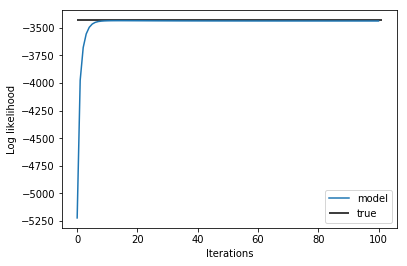

In [6]:
fig, ax = plt.subplots(1,1)
ax.hlines(true_likelihood, 0, len(model_likelihood), label='true')
ax.plot(model_likelihood, label='model')
ax.set_xlabel('Iterations')
ax.set_ylabel('Log likelihood')
ax.legend()

other metrics that will be included soon:
- error estimates for parameters (rotation + frobenius)
- verifying latents are the same post rotation
- comparing eigenvec/val between estimates and true params
- quantify noise reduction between estimates and true latents in terms of noise magnitude
- use poisson spikes generation, see how above convergence measures change